# Experiment with recognizing times from MK8DX screenshots

In [166]:
import tempfile
from PIL import Image, ImageOps
from pathlib import Path
import os
import datetime as dt
import subprocess
from mindee import Client, AsyncPredictResponse, product
from dotenv import load_dotenv, dotenv_values
from pprint import pprint
import polars as pl
import openpyxl
from openpyxl.utils.dataframe import dataframe_to_rows
import pickle
import argparse

In [168]:
# Make Mindee API key accessible
load_dotenv()

True

In [3]:
# Init a new client
mindee_client = Client(api_key=os.getenv('MINDEE_API_KEY'))

endpoint_kind_1 = mindee_client.create_endpoint(
    account_name="polimath",
    endpoint_name="mk8dx_screen_capture_kind_1",
    version="1"
)
endpoint_kind_2 = mindee_client.create_endpoint(
    account_name="polimath",
    endpoint_name="mk8dx_screen_capture_kind_2",
    version="1"
)
#endpoint_kind_3 = mindee_client.create_endpoint(
#    account_name="polimath",
#    endpoint_name="mk8dx_screen_capture_kind_3",
#    version="1"
#)

## Identify which kind of image we have

We need a way to distinguish among at least three image formats:
1. Blue background, track name at bottom, combo listed with text.
2. Track background, racing alone (no ghost).
3. Track background, racing against ghost.

We also need a way to identify how many laps there are in the race. This can be either three or seven, with three being the most common.

### Determine kind of image

In [6]:
class ImageToOCR:
    def __init__(self, image_file: Path):
        self.image_file = image_file

    @property
    def ocr(self) -> str:
        ocr_result = subprocess.run(["ocrs", self.image_file], stdout=subprocess.PIPE)
        return ocr_result.stdout.decode("utf-8").strip()

    def ocr_box(self, box: list[4]) -> str:
        """
        Given a box defining opposite corners of a box in pixels,
        return the text ocr'ed from that box.

        box = a list of integers: [x1, y1, x2, y2]
        """
        original_image = Image.open(self.image_file)
        cropped_image = original_image.crop(box)
        with tempfile.NamedTemporaryFile(delete=False, suffix=".jpg") as temporary_file:
            temporary_file_name = temporary_file.name
        cropped_image.save(temporary_file_name)
        ocr_result = subprocess.run(
            ["ocrs", temporary_file_name], stdout=subprocess.PIPE
        )

        return ocr_result.stdout.decode("utf-8").strip()

    def ocr_mindee(self, kind: int) -> dict:
        input_doc = mindee_client.source_from_path(self.image_file)
        if kind in [1, 2, 3]:
            result: AsyncPredictResponse = mindee_client.enqueue_and_parse(
                product.GeneratedV1,
                input_doc,
                endpoint=eval("endpoint_kind_" + str(kind)),
            )
            return {
                k: v.value
                for k, v in result.document.inference.prediction.fields.items()
            }
        else:
            return {}

    @property
    def kind(self) -> int:
        with Image.open(self.image_file) as f:
            image_size = f.size

        lower_right_OK = self.ocr_box(box=[1170, 646, 1225, 682])
        lower_right_lap_2_number = self.ocr_box(box=[1020, 456, 1044, 480])
        last_digit_top_lap_2 = self.ocr_box(box=[1162, 220, 1183, 253])

        if image_size != (1280, 720):
            # Wrong size; can't be a screen capture from the Switch
            image_kind = 0
        elif lower_right_OK == "OK":
            # Looks for 'OK' in the lower left corner
            image_kind = 1
        elif lower_right_lap_2_number == "2":
            # Looks for the second lap in the lower box of times.
            # Assumes that the course has three laps.
            image_kind = 3
        elif len(last_digit_top_lap_2) is not None:
            # If there's no lower box of times, looks for the second lap
            # in the upper box of times.
            image_kind = 2
        else:
            # Can't positively identify as one of the defined kinds.
            image_kind = 0
        return image_kind

    def pull_data_from_image(self, kind=None) -> dict:
        """
        Pulls information from image. Returns a dictionary of strings.
        """
        if kind is None:
            return self.pull_data_from_image(kind=self.kind)
        if kind not in [1, 2, 3]:
            return {}
        else:
            output = self.ocr_mindee(kind=kind)
            output["overall_time"] = self.calc_overall_time(output)
            output["kind"] = kind
            output["image_file_name"] = self.image_file.stem + ".jpg"
            output["datetime_processed"] = dt.datetime.now().strftime(
                "%Y-%m-%d %H:%M:%S.%f"
            )
            output["race_end_datetime"] = dt.datetime.strptime(
                self.image_file.stem[0:14], "%Y%m%d%H%M%S"
            ).strftime("%Y-%m-%d %H:%M:%S")
            return output

    def calc_overall_time(self, output_from_mindee: dict) -> str:
        lap_timedeltas = [
            dt.datetime.strptime(v + "000", "%M:%S.%f") - dt.datetime(1900, 1, 1)
            for k, v in output_from_mindee.items()
            if len(k) > 2 and k[0:3] == "lap"
        ]
        overall_timedelta = sum(lap_timedeltas, dt.timedelta(seconds=0))
        return "{:02}:{:2}.{:03}".format(
            overall_timedelta.seconds // 60,
            overall_timedelta.seconds % 60,
            overall_timedelta.microseconds // 1000,
        )

In [7]:
# kind 1
image_file = Path('data/test_images/2019102710534900_c.jpg')
image_kind = ImageToOCR(image_file).kind
print(image_file.name + ': ' + str(image_kind))
image_ocd_data = ImageToOCR(image_file).pull_data_from_image(image_kind)
with open('./kind_1_test_ocr_output.pkl', 'wb') as f:
    pickle.dump(image_ocd_data, f)
pprint(image_ocd_data)

2019102710534900_c.jpg: 1
{'datetime_processed': '2025-01-03 17:11:09.975922',
 'glider': 'Gold Glider',
 'image_file_name': '2019102710534900_c.jpg',
 'kind': 1,
 'lap_1_time': '0:28.703',
 'lap_2_time': '0:28.330',
 'lap_3_time': '0:27.706',
 'overall_time': '01:24.739',
 'race_end_datetime': '2019-10-27 10:53:49',
 'racer': 'Ander',
 'track': 'GCN Yoshi Circuit',
 'vehicle': 'Biddybuggy',
 'wheels': 'Roller'}


In [9]:
# kind 2
image_file = Path('data/test_images/2023062418352400_s.jpg')
image_kind = ImageToOCR(image_file).kind
print(image_file.name + ': ' + str(image_kind))
pprint(ImageToOCR(image_file).pull_data_from_image(image_kind))

data/test_images/2023062418352400_s.jpg: 2
{'character_name': 'Dry Bones', 'glider': 'Cloud Glider', 'lap_1_time': '0:37.501', 'lap_2_time': '0:33.703', 'lap_3_time': '0:34.005', 'overall_time': '01:45.209', 'vehicle': 'Biddybuggy', 'wheels': 'Azure Roller', 'kind': 2, 'image_file_name': 'data/test_images/2023062418352400_s.jpg', 'datetime_processed': '2024-12-31 16:24:10.759226', 'race_end_datetime': '2023-06-24 18:35:24'}


In [ ]:
# kind 3
image_file = Path('data/test_images/2023070714422000_s.jpg')
image_kind = ImageToOCR(image_file).kind
print(image_file.name + ': ' + str(image_kind))
pprint(ImageToOCR(image_file).pull_data_from_image(image_kind))

In [16]:
# kind other
image_file = Path('data/test_images_source/dog.jpg')
image_kind = ImageToOCR(image_file).kind
print(image_file.name + ': ' + str(image_kind))
pprint(ImageToOCR(image_file).pull_data_from_image(image_kind))

dog.jpg: 0
{}


- Read .jpg files from given folder.
- Check to see if there is a cache file. If so:
    - Read existing data from cache.
    - Check file names against those already processed in cache, collect list of files not processed.
- Process new files.
- Append new data to existing data.
- Update cache file.
- If there's an existing Excel file, append the new data. Otherwise, save the data to an Excel file.

In [117]:
# set some constants/runtime paramters
folder_to_process = Path(os.getcwd(), 'data/test_images')
cache_file_name = Path(os.getcwd(), 'cache.pkl')
target_excel_file = Path(os.getcwd(), 'MK8DX_lap_times.xlsx')

cache_exists = os.path.exists(cache_file_name)
target_excel_exists = os.path.exists(target_excel_file)

In [124]:
def read_list_of_files(folder: Path) -> set[Path]:
    """
    Given a folder Path object, return a list of file Path objects
    of the *.jpg files in that folder. Does not go into subfolders.
    """
    all_files_in_folder = Path(folder).glob('*.jpg')
    all_jpg_files = [x for x in all_files_in_folder if x.is_file()]
    return set(all_jpg_files)

In [109]:
def process_list_of_files(file_names: list[Path]) -> list[dict]:
    """
    Given a list of files (complete paths) process the files and return a list of
    dictionaries with the processed ocr text.

    Note that each dict may not have all of the desired columns. When merging, we need
    a base record with all of the columns to ensure that all are present in the
    output and that they are in the desired order.
    """
    raw_ocr_results = {f.name:ImageToOCR(f).pull_data_from_image() for f in file_names}
    # purge entries for non-screen caps
    ocr_results = [v for k,v in raw_ocr_results.items() if v != {}]
    return ocr_results

In [125]:
def load_cache_and_list_of_paths_to_process(folder_to_process: Path, cache_file_name: Path) -> tuple[pl.DataFrame, set[Path]]:
    """
    Given a folder to process and a cache file name, load the cache file and
    return the cache as a DataFrame and a set of Path objects to process.
    """
    all_jpg_files = read_list_of_files(folder_to_process)

    if cache_exists:
        # Read cache, get file names, read against new file names.
        # Remove cached file names from all_jpg_files and set file_to_process.
        cached_df = pickle.load(cache_file_name)
        cached_file_names = set(cached_df['image_file_name'].to_series().to_list())
        files_to_process = all_jpg_files - cached_file_names
    else:
        # No cache, so process all files.
        cached_df = None
        files_to_process = all_jpg_files
    return cached_df, files_to_process

cached_df, files_to_process = load_cache_and_list_of_paths_to_process(folder_to_process, cache_file_name)

{WindowsPath('c:/Users/steve/OneDrive/Documents/GitHub/mk8dx-lap-time-tracker/data/test_images/2019102710534900_c.jpg')}


In [93]:
# Try not to run this too much in testing.
processed_ocr_output = process_list_of_files(files_to_process)

In [112]:
def convert_ocr_dict_to_polars(x: dict) -> pl.DataFrame:
    """
    Takes the generated ocr output (a list of dictionaries) and converts it to a polars
    DataFrame. It starts with an empty row with all of the target columns in the target
    order. The rows with data will then fall in line and there will be no missing columns.
    """
    field_names_in_order = ['race_end_datetime',
                            'racer',
                            'character_name',
                            'track',
                            'vehicle',
                            'wheels',
                            'glider',
                            'overall_time',
                            'lap_1_time',
                            'lap_2_time',
                            'lap_3_time',
                            'image_file_name',
                            'kind',
                            'datetime_processed'
                            ]
    default_row = [{k:'' for k in field_names_in_order}]
    output_df = pl.DataFrame(default_row + x).filter(pl.col("image_file_name") != '')
    return output_df

In [119]:
new_records_df = convert_ocr_dict_to_polars(processed_ocr_output)
new_records_df

race_end_datetime,racer,character_name,track,vehicle,wheels,glider,overall_time,lap_1_time,lap_2_time,lap_3_time,image_file_name,kind,datetime_processed
str,str,str,str,str,str,str,str,str,str,str,str,str,str
"""2019-10-27 10:53:49""","""Ander""",null,"""GCN Yoshi Circuit""","""Biddybuggy""","""Roller""","""Gold Glider""","""01:24.739""","""0:28.703""","""0:28.330""","""0:27.706""","""2019102710534900_c.jpg""","""1""","""2024-12-31 17:42:20.623803"""


In [ ]:
# Output cache and Excel

# Save all to cache (overwrite)
def update_cache(cache_file_name: Path, new_df: pl.DataFrame, old_cache_df: pl.DataFrame=None) -> None:
    cached_and_new_df = pl.concat(cached_df, new_records_df)
    with open(cache_file_name, "wb") as f:
        pickle.dump(cached_and_new_df, f)
    return None

update_cache(cache_file_name=cache_file_name, new_df=new_records_df, old_cache_df=cached_df)

def output_to_excel(target_excel_file: Path, new_df: pl.DataFrame) -> None:
    if os.path.exists(target_excel_file):
        # Append to Excel (just new)
        excel_workbook = openpyxl.load_workbook(target_excel_file)
        excel_worksheet = excel_workbook['data']
        excel_worksheet.append(new_df)
        excel_workbook.save(target_excel_file)
    else:
        # Save all to Excel
        excel_workbook = openpyxl.workbook.Workbook()
        excel_workbook.create_sheet(title='data')
        excel_worksheet.append(new_df)
        excel_workbook.save(target_excel_file)
    return None

output_to_excel(target_excel_file=target_excel_file, new_df=new_records_df)

In [50]:
with open('./cache.pkl', "rb") as f:
    cache = pickle.load(f)
cache

race_end_datetime,racer,character_name,track,vehicle,wheels,glider,overall_time,lap_1_time,lap_2_time,lap_3_time,image_file_name,kind,datetime_processed
str,str,str,str,str,str,str,str,str,str,str,str,str,str
"""2023-06-21 17:46:31""","""Ander""",null,"""DS Wario Stadium""","""Inkstriker""","""Azure Roller""","""Gold Glider""","""01:58.492""","""0:40.267""","""0:39.104""","""0:39.121""","""2023062117463100_s.jpg""","""1""","""2025-01-04 13:57:14.220891"""
"""2019-10-27 10:54:07""","""Ander""",null,"""Dragon Driftway""","""Biddybuggy""","""Leaf Tires""","""Cloud Glider""","""""",null,null,null,"""2019102710540700_c.jpg""","""1""","""2025-01-04 13:57:22.117200"""
"""2019-10-27 10:53:49""","""Ander""",null,"""GCN Yoshi Circuit""","""Biddybuggy""","""Roller""","""Gold Glider""","""01:25.399""","""0:28.703""","""0:28.990""","""0:27.706""","""2019102710534900_c.jpg""","""1""","""2025-01-04 13:57:26.264904"""
"""2023-07-03 16:20:14""",null,"""Wario""",null,"""Standard Kart""","""Crimson Slim""","""Super Glider""","""""",null,null,null,"""2023070316201400_s.jpg""","""2""","""2025-01-04 13:57:34.169290"""
"""2019-10-27 10:55:15""","""Ander""",null,"""Twisted Mansion""","""Mach 8""","""Cyber Slick""","""Gold Glider""","""02:02.374""","""0:41.966""","""0:40.190""","""0:40.218""","""2019102710551500_c.jpg""","""1""","""2025-01-04 13:57:38.337488"""
"""2023-06-24 18:35:24""",null,"""Dry Bones""",null,"""Biddybuggy""","""Azure Roller""","""Cloud Glider""","""01:44.609""","""0:37.501""","""0:33.103""","""0:34.005""","""2023062418352400_s.jpg""","""2""","""2025-01-04 13:57:42.382780"""
"""2023-06-24 18:35:27""",null,"""Dry Bones""",null,"""Biddybuggy""","""Azure Roller""","""Cloud Glider""","""""","""0:37.50""","""0:33.103""","""0:34.005""","""2023062418352700_s.jpg""","""2""","""2025-01-04 13:57:46.600341"""
"""2023-07-03 18:24:17""",null,"""Ander""",null,"""Sport Bike""","""Metal""","""Super Glider""","""01:15.080""","""0:25.833""","""0:24.496""","""0:24.751""","""2023070318241700_s.jpg""","""2""","""2025-01-04 13:57:50.727783"""
"""2023-06-21 17:46:04""","""Ander""",null,"""Wii DK Summit""","""Teddy Buggy""","""GLA Tires""","""Cloud Glider""","""02:06.655""","""0:43.277""","""0:41.819""","""0:41.559""","""2023062117460400_s.jpg""","""1""","""2025-01-04 13:57:54.819602"""


In [47]:
def reverse_image_colors(source_image_file: Path, target_image_file: Path=None) -> None:
    """
    Given an image file, reverse the colors and save the file.
    If target_image_file is None, overwrite the source image.
    """
    with Image.open(source_image_file) as f_in:
        inverted_image = ImageOps.invert(f_in)
    if target_image_file is None:
        inverted_image.save(source_image_file)
    else:
        inverted_image.save(target_image_file)
    return None

In [48]:
reverse_image_colors(Path('data/test_images/2019102710534900_c.jpg'))

In [74]:
with open('mindee_output_tmpvg8b210z.pkl', "rb") as f:
    mindee_output = pickle.load(f)

In [77]:
pprint(mindee_output.get_raw_output())

AttributeError: 'AsyncPredictResponse' object has no attribute 'get_raw_output'

In [86]:
image_file = Path('data/test_images/2023070316201400_s.jpg')
image_kind = 2

with Image.open(image_file) as f:
    cropped_reversed_image = ImageOps.invert(f).crop((1048, 112, 1200, 299))

cropped_reversed_image.save('data/test_images/kind_2_cropped_reversed_times.jpg')

In [79]:
def call_mindee(kind: int, input_file_name) -> dict:
        """
        Given a kind of image and input_file_name, return the raw OCR results from Mindee.
        """
        input_doc = mindee_client.source_from_path(input_file_name)
        result: AsyncPredictResponse = mindee_client.enqueue_and_parse(
            product.GeneratedV1,
            input_doc,
            endpoint=eval("endpoint_kind_" + str(kind)),
        )

        output = {
            k: v.value
            for k, v in result.document.inference.prediction.fields.items()
        }
        return output

In [84]:
call_mindee(2, 'data/test_images/kind_2_cropped_times.jpg')

{'character_name': None,
 'glider': None,
 'lap_1_time': '0:26.857',
 'lap_2_time': '0:36.249',
 'lap_3_time': '0:25.082',
 'overall_time': '1:28.988',
 'vehicle': None,
 'wheels': None}

In [85]:
image_file = Path('data/test_images/2023070316201400_s.jpg')
image_kind = 2

cropped_overall_time_image = Image.open(image_file).crop([1039, 113, 1210, 152])
cropped_overall_time_image.save('data/test_images/kind_2_cropped_overall_time.jpg')

In [88]:
ocr_result = subprocess.run(["ocrs", "data/test_images/kind_2_cropped_overall_time.jpg"], stdout=subprocess.PIPE)
print(ocr_result.stdout.decode("utf-8").strip())

128.988


# Try ImageOps.autocontrast() on the lap times

In [89]:
with Image.open(image_file) as img:
    cropped_autocontrast_image = ImageOps.autocontrast(img).crop((1048, 112, 1200, 299))

cropped_autocontrast_image.save('data/test_images/kind_2_cropped_autocontrast_times.jpg')

In [90]:
with Image.open(image_file) as img:
    cropped_equalize_image = ImageOps.equalize(img).crop((1048, 112, 1200, 299))

cropped_equalize_image.save('data/test_images/kind_2_cropped_equalize_times.jpg')

# Refactor OCRing to use a dictionary of parameters

In [114]:
# Image kind identification uses ocrs without processing other than cropping.
image_kind_identification_parameters = {
    'order_to_check': [1,3,2],
    1: {'title': 'lower_right_OK',
        'box': [1170, 646, 1225, 682],
        'expected_value': ' == "OK"'
    },
    2: {'title': 'last_digit_top_lap_2',
        'box': [1162, 220, 1183, 253],
        'expected_value': ' != None'
    },
    3: {'title': 'lower_right_lap_2_number',
        'box': [1020, 456, 1044, 480],
        'expected_value': ' == "2"'
    }
}

In [206]:

# This defines how to extract fields from the image once the kind has been identified.
# Each kind has a list of extractions that is applied in order. Each extraction is a
# dictionary.
image_processing_parmeters = {
    1: [{
            'framework': 'mindee',
            'box': [1, 1, 1280, 720],
            'transformations': [],
            'endpoint_name': 'mk8dx_screen_capture_kind_1',
            'endpoint_version': '1',
            'fields': ['racer', 'track', 'vehicle', 'wheels', 'glider', 'overall_time', 'lap_1_time', 'lap_2_time', 'lap_3_time']
        }],
    2: [{
            'framework': 'mindee',
            'box': [1, 1, 1280, 720],
            'transformations': [],
            'endpoint_name': 'mk8dx_screen_capture_kind_2',
            'endpoint_version': '1',
            'fields': ['character_name', 'vehicle', 'wheels', 'glider', 'overall_time', 'lap_1_time', 'lap_2_time', 'lap_3_time']
        },
        {
            'framework': 'ocrs',
            'box': [1, 1, 1280, 720],
            'transformations': [],
            'fields': ['something']
        }],
    3: [{
            'framework': 'mindee',
            'box': [1, 1, 1280, 720],
            'transformations': [],
            'endpoint_name': 'mk8dx_screen_capture_kind_3',
            'endpoint_version': '1',
            'fields': ['racer', 'vehicle', 'wheels', 'glider', 'overall_time', 'lap_1_time', 'lap_2_time', 'lap_3_time',
                       'opponent', 'vehicle', 'wheels', 'glider', 'overall_time', 'lap_1_time', 'lap_2_time', 'lap_3_time']
        },
        {
            'framework': 'ocrs',
            'box': [1, 1, 1280, 720],
            'transformations': [],
            'fields': ['something']
        }],
    4: [{
            'framework': 'mindee',
            'box': [1, 1, 1280, 720]
        },
        {
            'framework': 'ocrs',
            'fields': ['something']
        }]
}

In [ ]:
def validate_extraction(extraction: dict) -> bool:
    """
    Given an extraction dictionary, return True if the extraction
    is correctly formatted and False otherwise.
    """
    if not isinstance(extraction, dict):
        return False
    if not all([x in extraction for x in ['framework', 'fields']]):
        return False
    if not 'mindee' in extraction['framework'] and not 'ocrs' in extraction['framework']:
        return False
    if extraction['framework'] == 'mindee':
        if not all([x in extraction for x in ['endpoint_name', 'endpoint_version']]):
            return False
    if not isinstance(extraction['endpoint_version'], str):
        return False
    return True

In [ ]:
############# THIS NEEDS TO BE FINISHED #############

def validate_all_extractions(extractions: list[dict]) -> bool:
    """
    Given a list of extractions, return True if all of the extractions
    are correctly formatted and False otherwise.
    """
    return all([validate_extraction(x) for x in extractions])

In [212]:
def transform_image_and_save(image_file: Path, 
                             box: list[int]=None,
                             transformations: list[dict]=None
    ) -> Path:
    """
    Given an image file and a list of transformations, perform the transformations
    and return the Path to a temporary file with the transformed image.

    transformations = a list of dictionaries, each a transformation from the ImageOps module.

    Examples: 
    transformations =
    [
        {'transformation': 'autocontrast',
         'parameters': {'cutoff': 0.5, 'preserve_tone': True}},
        {'transformation': 'expand', 
         'parameters': {border: 10}},
        {'transformation': 'grayscale'}} # Note that if there are no paremeters, then the dictionary can be simplified.
    ]
    
    List of transformations: autocontrast, colorize, scale, SuppoetGetMesh, deform, equalize,
    expand, flip, grayscale, invert, mirror, posterize, solarize, exif_transpose
    Refer to https://pillow.readthedocs.io/en/stable/reference/ImageOps.html for the complete list.

    Cropping with the specified box is always the first transformation.
    """
    with Image.open(image_file) as img:
        if box is not None:
            img = img.crop(box)
        if transformations is not None:
            for t in transformations:
                if 'parameters' in t:
                    img = eval("ImageOps." + t['transformation'])(img, **t['parameters'])
                else:
                    img = eval("ImageOps." + t['transformation'])(img)
        
        if debug:
            temp_dir = Path(os.getcwd())
        else:
            temp_dir = None

        with tempfile.NamedTemporaryFile(delete=False, suffix=".jpg", dir=temp_dir) as temporary_file:
            temporary_file_name = temporary_file.name
            img.save(temporary_file_name)
    return Path(temporary_file_name)

In [144]:
# Check transform_image_and_save function

debug = True

test_transformations = []
test_box = [1048, 112, 1200, 299]

In [138]:
test_transformations = [{'transformation': 'autocontrast',
                         'parameters': {'cutoff': 0.5, 'preserve_tone': True}}]
test_box = None

In [152]:
test_transformations = [{'transformation': 'equalize'}]
test_box = None

In [156]:
test_transformations = [{'transformation': 'grayscale'}]
test_box = None

c:\Users\steve\OneDrive\Documents\GitHub\mk8dx-lap-time-tracker\tmpbr90dxnj.jpg


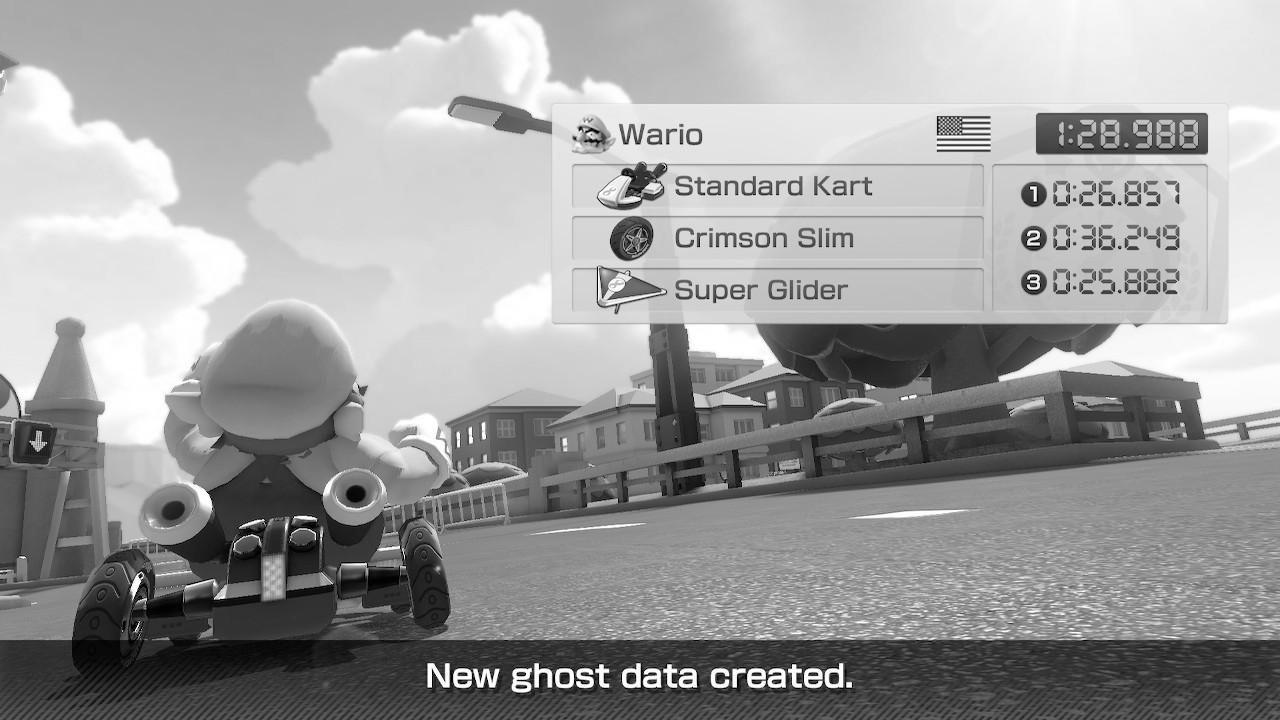

In [157]:
test_file_name = transform_image_and_save(image_file=Path('data/test_images/2023070316201400_s.jpg'), 
                                          box=test_box,
                                          transformations=test_transformations)
print(test_file_name)
display(Image.open(test_file_name))
os.remove(test_file_name)

In [222]:
def ocr_image(image_file: Path, 
              framework: str,
              endpoint_name: str=None,
              endpoint_version: str=None
    ) -> dict:
    """
    Given an image Path (which may be cropped and transformed)
    and a framework, return the text ocr'ed from that box in a 
    dictionary where key is a field name and value is a string.

    box = a list of integers representing pixels: [x1, y1, x2, y2]
    framework = a string: 'mindee' or 'ocrs'
    """

    if framework == 'mindee':
        mindee_client = Client(api_key=os.getenv('MINDEE_API_KEY'))
        input_doc = mindee_client.source_from_path(image_file)
        endpoint = mindee_client.create_endpoint(
            account_name="polimath",
            endpoint_name=endpoint_name,
            version=endpoint_version
        )
        result: AsyncPredictResponse = mindee_client.enqueue_and_parse(
            product.GeneratedV1,
            input_doc,
            endpoint=endpoint
        )
        del mindee_client
        return { k: v.value for k, v in result.document.inference.prediction.fields.items() }
    elif framework == 'ocrs':
        with tempfile.NamedTemporaryFile(delete=False, suffix=".jpg") as temporary_file:
            temporary_file_name = temporary_file.name
        Image.open(image_file).save(temporary_file_name)
        ocr_result = subprocess.run(["ocrs", temporary_file_name], stdout=subprocess.PIPE)
        return {'ocr_result': ocr_result.stdout.decode("utf-8").strip()}
    else:
        return {}

In [196]:
# Test ocr_image function

image_file = Path('data/test_images/2023070316201400_s.jpg')
pprint(ocr_image(image_file, framework='mindee', endpoint_name='mk8dx_screen_capture_kind_2', endpoint_version='1'))

In [226]:
def identify_kind(image_file: Path) -> int:
    """
    Given an image, return the kind of image.
    """
    if Image.open(image_file).size != (1280, 720):
        return 0
    for kind_to_check in image_kind_identification_parameters['order_to_check']:
        parameters = image_kind_identification_parameters[kind_to_check]
        transformed_file_name = transform_image_and_save(image_file, box=parameters['box'])
        ocr_result = ocr_image(transformed_file_name, framework='ocrs')['ocr_result']
        condition_to_check = 'ocr_result' + parameters['expected_value']
        if debug:
            print(f"Checking condition: {condition_to_check}")
        if eval(condition_to_check):
            return kind_to_check
    return 0

In [128]:
# Check the identify_kind function

test_file_name = Path('data/test_images/2019102710534900_c.jpg')
test_kind = identify_kind(test_file_name)
print(f"{test_file_name} is of kind: {test_kind}")

test_file_name = Path('data/test_images/2023070316201400_s.jpg')
test_kind = identify_kind(test_file_name)
print(f"{test_file_name} is of kind: {test_kind}")

test_file_name = Path('data/test_images/2023070714422000_s.jpg')
test_kind = identify_kind(test_file_name)
print(f"{test_file_name} is of kind: {test_kind}")

test_file_name = Path('data/test_images/dog.jpg')
test_kind = identify_kind(test_file_name)
print(f"{test_file_name} is of kind: {test_kind}")

Checking condition: ocr_result == "OK"
data\test_images\2019102710534900_c.jpg is of kind: 1
Checking condition: ocr_result == "OK"
Checking condition: ocr_result == "2"
Checking condition: ocr_result != None
data\test_images\2023070316201400_s.jpg is of kind: 2
Checking condition: ocr_result == "OK"
Checking condition: ocr_result == "2"
data\test_images\2023070714422000_s.jpg is of kind: 3
data\test_images\dog.jpg is of kind: 0


In [228]:
def extract_fields_from_image(image_file: Path) -> dict:
    """
    Given an image file, return a dictionary of fields extracted from the image.
    """
    kind = identify_kind(image_file)
    if kind == 0:
        return {}
    
    output = {}
    kind_extractions = image_processing_parmeters[kind] # This is a list for the given kind.
    for parameters in kind_extractions: # This is a dict for each extraction.
        temp_file_name = transform_image_and_save(
            image_file, 
            box=parameters.get('box', None), 
            transformations=parameters. get('transformations', None)
        )
        ocr_output = ocr_image(temp_file_name, 
            framework=parameters['framework'], 
            endpoint_name=parameters.get('endpoint_name', None),
            endpoint_version=parameters.get('endpoint_version', None)
        )

        if parameters['framework'] == 'ocrs':
            output.update({parameters['fields'][0]: ocr_output['ocr_result']})
        elif parameters['framework'] == 'mindee':
            output.update(ocr_output)
        else:
            pass
        
        os.remove(temp_file_name)
    return output

In [229]:
# Test extract_fields_from_image function.

test_file_name = Path('data/test_images/2019102710534900_c.jpg')
print(f"Image kind: {identify_kind(test_file_name)}")
pprint(extract_fields_from_image(test_file_name))
print()


Image kind: 1
{'glider': 'Gold Glider',
 'lap_1_time': '0:28.703',
 'lap_2_time': None,
 'lap_3_time': '0:27.706',
 'overall_time': '1:24.739',
 'racer': 'Ander',
 'something': 'MIOKAs\n'
              'Ander\n'
              '? 1:24.735 QW\n'
              '0 0:28.88\n'
              '2 0:28.33\n'
              '3 :2. HE\n'
              'Biddybuggy\n'
              'Roller\n'
              'Gold Glider\n'
              '?\n'
              'Solo Race\n'
              'Race against Ghost e\n'
              'A\n'
              'View Ghost\n'
              'O\n'
              'Online Ghosts\n'
              '"Uplead Ghost Data\n'
              'N\n'
              'L0\n'
              'RAAFE\n'
              'GCN\n'
              'Yoshi Circuit\n'
              '?OK\n'
              '455',
 'track': 'GCN Yoshi Circuit',
 'vehicle': 'Biddybuggy',
 'wheels': None}



In [ ]:

test_file_name = Path('data/test_images/2023070316201400_s.jpg')
pprint(extract_fields_from_image(test_file_name))
print()

test_file_name = Path('data/test_images/2023070714422000_s.jpg')
pprint(extract_fields_from_image(test_file_name))
print()

test_file_name = Path('data/test_images/dog.jpg')
pprint(extract_fields_from_image(test_file_name))

In [225]:
debug = False